# JPEG Experiment

### Setting up the Data

In [1]:
# Setup the dataset
# You might have to adjust the data_path in settings.py and setup.py files
!python src/data/setup.py

No. of classes used:  200
100%|█████████████████████████████████████| 11788/11788 [09:20<00:00, 21.04it/s]


### Import Modules

In [1]:
# External Imports
import os
import re
from io import BytesIO
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import copy


# GitLab Code imports
sys.path.insert(0, './src/models/')
import src.training.train_and_test as tnt
from src.data.preprocess import mean, std
from settings import img_size, test_batch_size
from src.data.customdataset import CustomImageFolder
from src.utils.local_analysis import LocalAnalysis

# Random Seed
random_seed = 42
torch.manual_seed(random_seed)

### Prepare Data

In [2]:
# Directories
# You might have to change this directory path
directory = "/scratch/PPNet/datasets/cub200_cropped/"
directory_test = directory + "test_cropped/"

In [3]:
def JPEGcompression(image):
    """Applies JPEG compression of quality JPEG_QUALITY
    Args:
        image (PIL Image): uncompressed image
    Returns:
        Compressed Image
    """
    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=JPEG_QUALITY, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

In [4]:
normalize = transforms.Normalize(mean=mean, std=std)


# Test data, where 50% of the images are uncompressed and the other 
# 50% of the images are compressed. It is processed in the CustomImageFolder class
test_dataset = CustomImageFolder(
    directory_test,
    transform= transforms.Compose([   
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]),
    target_specific_transform= transforms.Compose([
        transforms.Lambda(JPEGcompression) # Apply JPEG compression as transform
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)


# Test data, where are the images are uncompressed
test_dataset_all_clean = datasets.ImageFolder(
    directory_test,
    transforms.Compose([ 
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader_all_clean = torch.utils.data.DataLoader(
    test_dataset_all_clean, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)

### Load Model

Model Paths:

- ResNet18 - jpeg_saved_models/resnet18/002/10_19push0.8019.pth
- ResNet34 - jpeg_saved_models/resnet34/002/10_18push0.8214.pth
- VGG19 - jpeg_saved_models/vgg19/002/10_19push0.8108.pth

Model Paths after followup experiments
- ResNet18 - /content/followup_experiments/resnet18/010/10_19push0.7632.pth
- ResNet34 - /content/followup_experiments/resnet34/010/10_18push0.7770.pth
- VGG19 - /content/followup_experiments/vgg19/010/10_19push0.7630.pth

In [35]:
# Select Network, and specify Experiment run
base_architecture = 'vgg19' #'resnet34', 'vgg19'
experiment_run = '010'

# Model directory
load_model_dir = '/cluster/scratch/fanconic/PPNet/followup_experiments/{}/{}/'.format(base_architecture, experiment_run)
load_model_name = '10_19push0.7630.pth'

# Specify the folder to save the images and logs
save_dir = '/cluster/scratch/fanconic/PPNet/jpeg_analysis_top5/' + base_architecture + '/' + experiment_run + '/'
! mkdir -p {save_dir}

In [36]:
loc_analysis = LocalAnalysis(load_model_dir, load_model_name, "", image_save_directory = save_dir)

load model from /cluster/scratch/fanconic/PPNet/followup_experiments/vgg19/010/10_19push0.7630.pth
model base architecture: vgg19
experiment run: 010
Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


### Check Model Performance

In [37]:
JPEG_QUALITY = 20

protopnet = loc_analysis.ppnet_multi

print("Accuracy on test data set original training jpeg scheme")
tnt.test(model=protopnet, dataloader=test_loader, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

print("Accuracy on test data set with no jpeg compressed classes")
tnt.test(model=protopnet, dataloader=test_loader_all_clean, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

Accuracy on test data set original training jpeg scheme
	test
	time: 	19.811330795288086
	cross ent: 	1.2414299922770466
	cluster: 	0.057415382358534585
	separation:	0.040011222602735305
	avg separation:	1.2656199726565132
	accu: 		74.59440800828443%
	l1: 		2385.10009765625
	p dist pair: 	3.293839931488037

Accuracy on test data set with no jpeg compressed classes
	test
	time: 	19.89269781112671
	cross ent: 	1.174785774329613
	cluster: 	0.053828436463814355
	separation:	0.03931367201409463
	avg separation:	1.2685967498812183
	accu: 		76.30307214359682%
	l1: 		2385.10009765625
	p dist pair: 	3.293839931488037



### Visualize Prototypes

Each example lists the top 5 prototypes and corresponding details for JPEG compressed image (left) and original image (right).

In [38]:
test_dirs = ["058.Pigeon_Guillemot/", "166.Golden_winged_Warbler/", "042.Vermilion_Flycatcher/"]
test_images = ["058.Pigeon_Guillemot/Pigeon_Guillemot_0079_40389.jpg", 
               "166.Golden_winged_Warbler/Golden_Winged_Warbler_0043_164476.jpg", 
               "042.Vermilion_Flycatcher/Vermilion_Flycatcher_0049_42380.jpg"]
test_labels = [57, 165, 42]
model_names = ["vgg19", "resnet34", "resnet18"]

JPEG compressed image
Predicted: 57	 Actual: 57	 Prediction is correct.
------------------------------
image index 0 in batch
Uncompressed image
Predicted: 57	 Actual: 57	 Prediction is correct.
------------------------------
image index 0 in batch


Compressed Image                                        Clean Image       \
      Prototype Id Rank Prototype Class Similarity Score Prototype Id Rank   
0              573    1              57         4.939289          573    1   
1              577    2              57         3.154044          577    2   
2             1408    3             140         3.138166          248    3   
3              579    4              57         3.110097         1408    4   
4              837    5              83         3.023595          837    5   

                                    
  Prototype Class Similarity Score  
0              57         4.347735  
1              57         3.348522  
2              24         3.191114  
3             140         3.172914  
4              83         3.152611

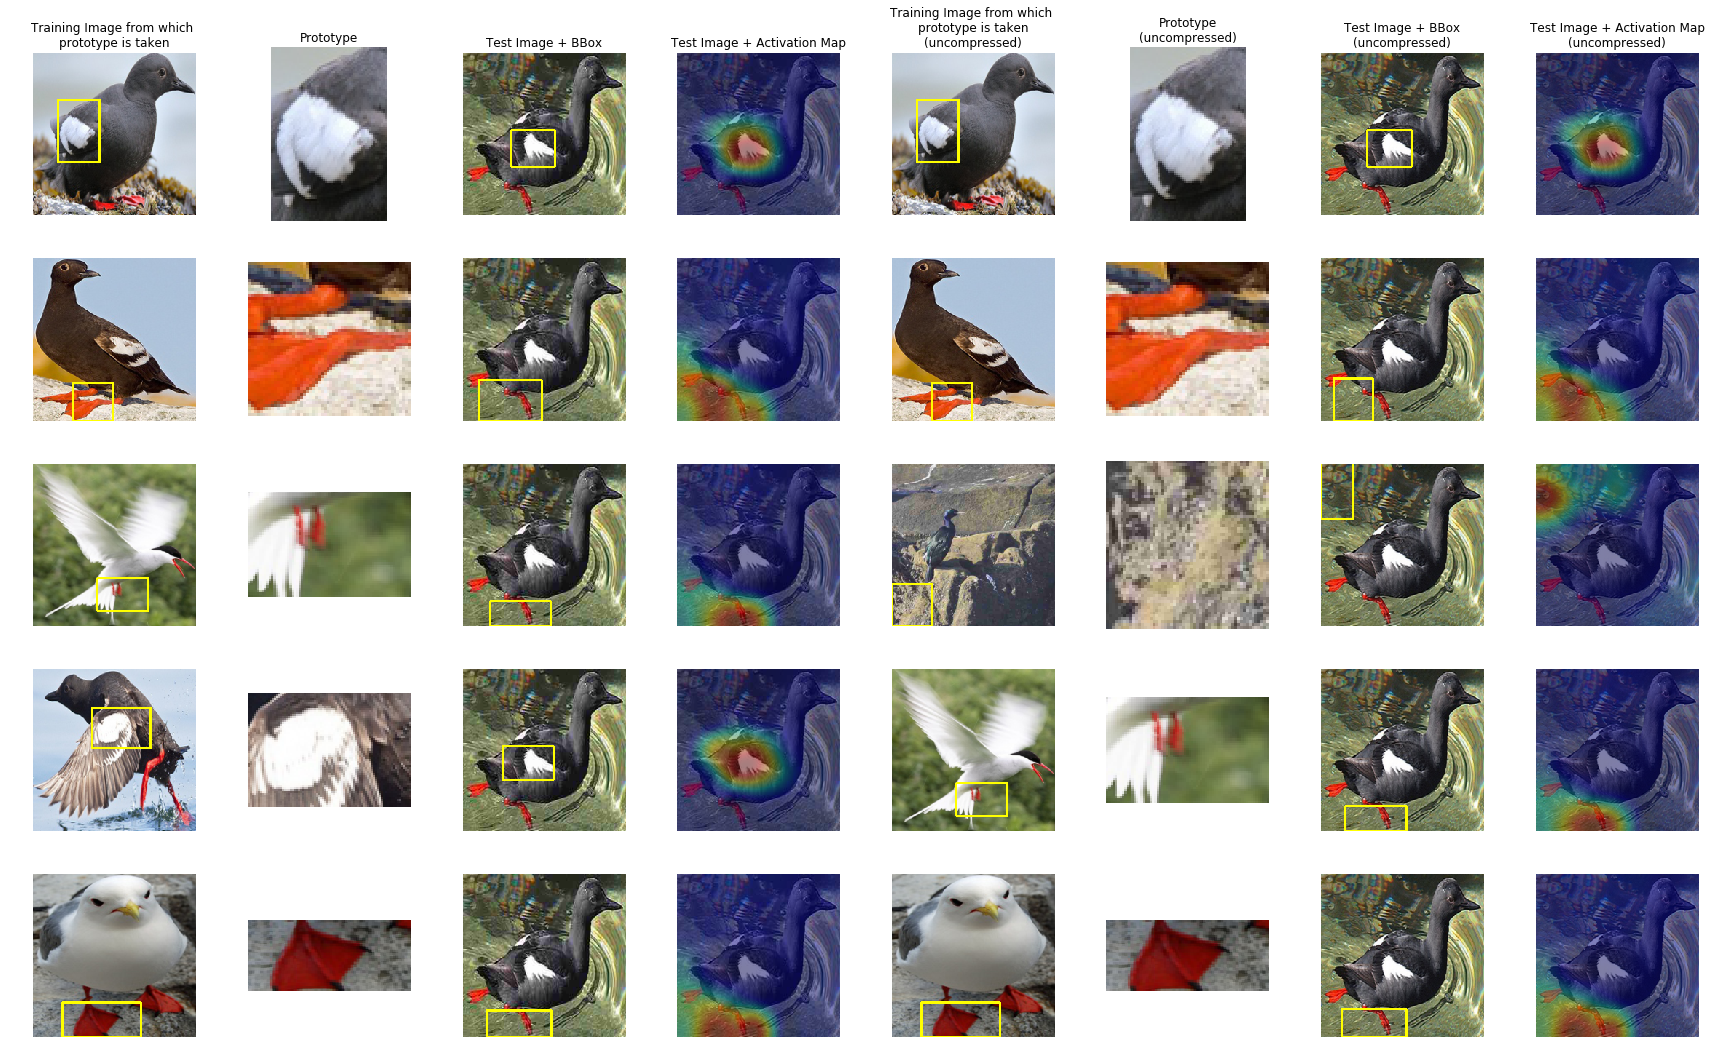

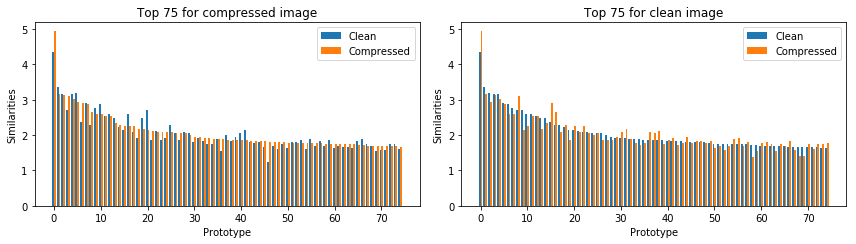


JPEG compressed image
Predicted: 165	 Actual: 165	 Prediction is correct.
------------------------------
image index 0 in batch
Uncompressed image
Predicted: 165	 Actual: 165	 Prediction is correct.
------------------------------
image index 0 in batch


Compressed Image                                        Clean Image       \
      Prototype Id Rank Prototype Class Similarity Score Prototype Id Rank   
0             1658    1             165         4.774724         1658    1   
1             1705    2             170         3.597231         1657    2   
2             1652    3             165         3.293475         1705    3   
3             1650    4             165         3.211727         1652    4   
4             1653    5             165         3.167786         1650    5   

                                    
  Prototype Class Similarity Score  
0             165         4.298979  
1             165         3.556626  
2             170         3.541605  
3             165         3.124341  
4             165         3.000043

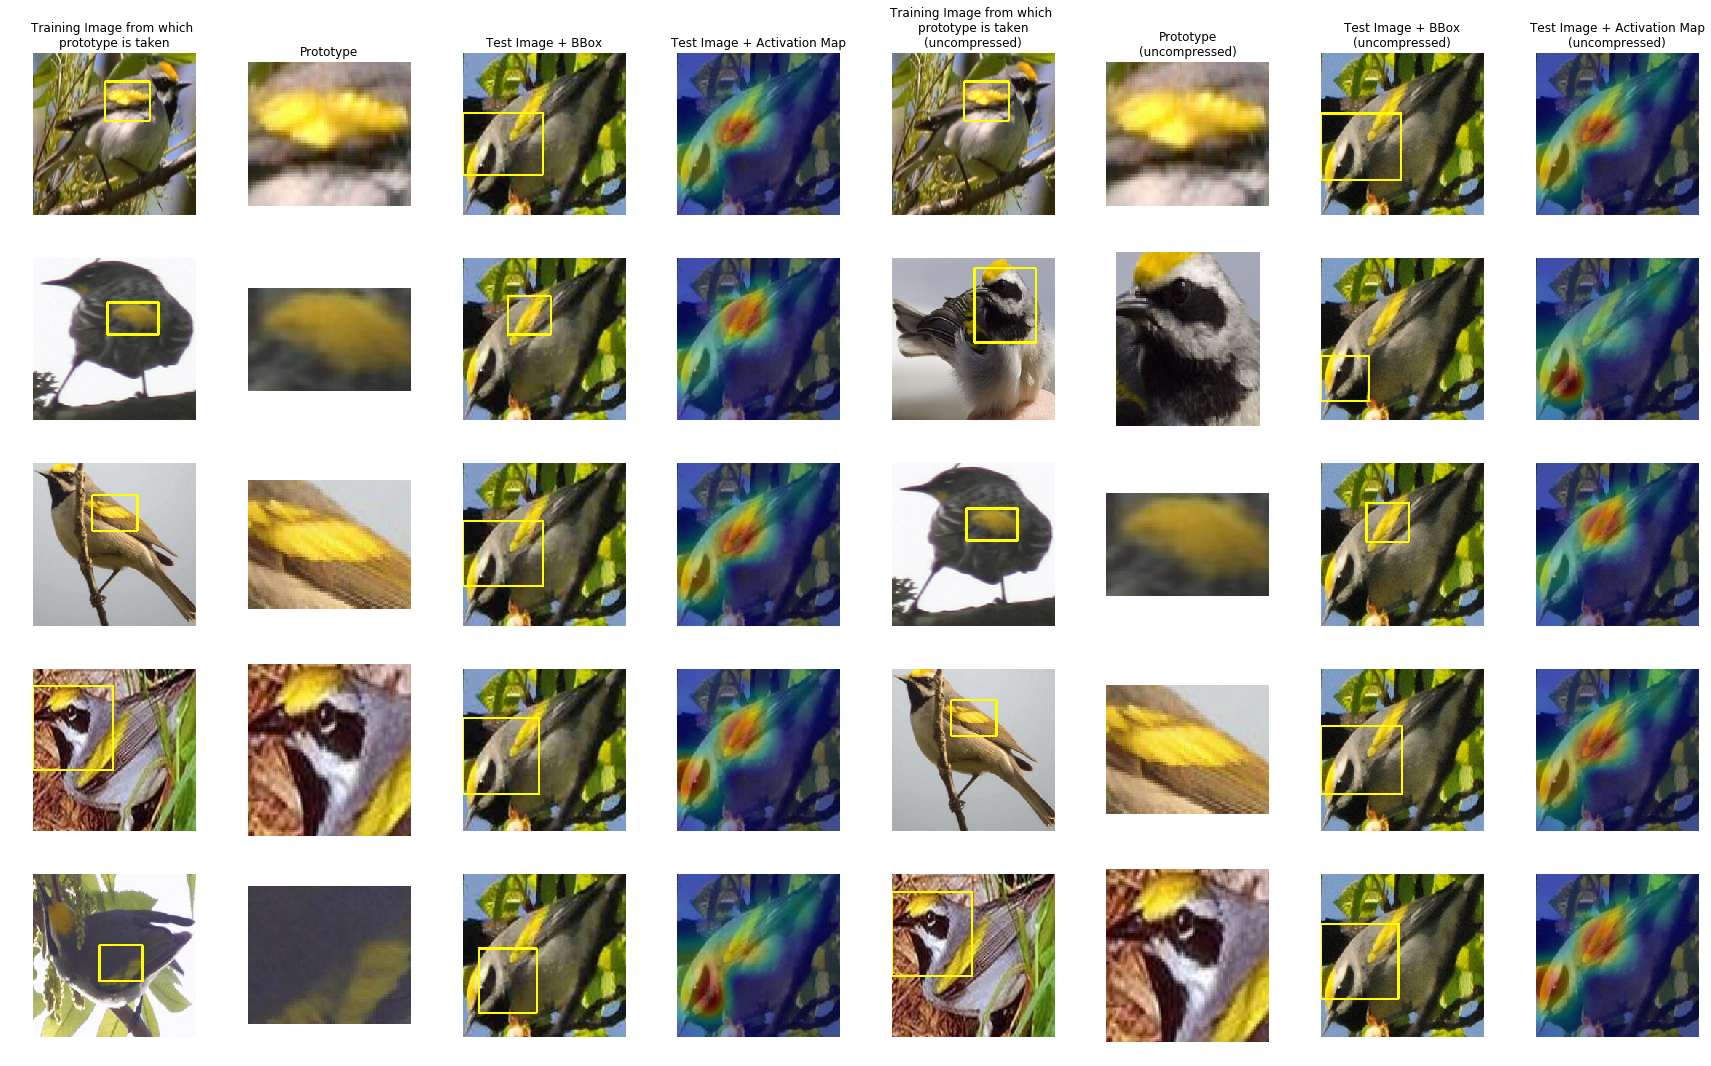

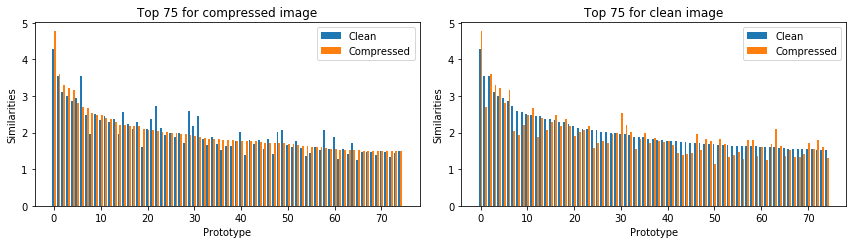


JPEG compressed image
Predicted: 41	 Actual: 42	 Prediction is wrong.
------------------------------
image index 0 in batch
Uncompressed image
Predicted: 41	 Actual: 42	 Prediction is wrong.
------------------------------
image index 0 in batch


Compressed Image                                        Clean Image       \
      Prototype Id Rank Prototype Class Similarity Score Prototype Id Rank   
0              413    1              41         4.908267          410    1   
1              417    2              41         4.545846          413    2   
2              410    3              41         4.171836          417    3   
3              414    4              41         3.830933          414    4   
4              151    5              15         3.440327          416    5   

                                    
  Prototype Class Similarity Score  
0              41         5.614088  
1              41         5.388377  
2              41         5.056262  
3              41         3.620971  
4              41         3.530739

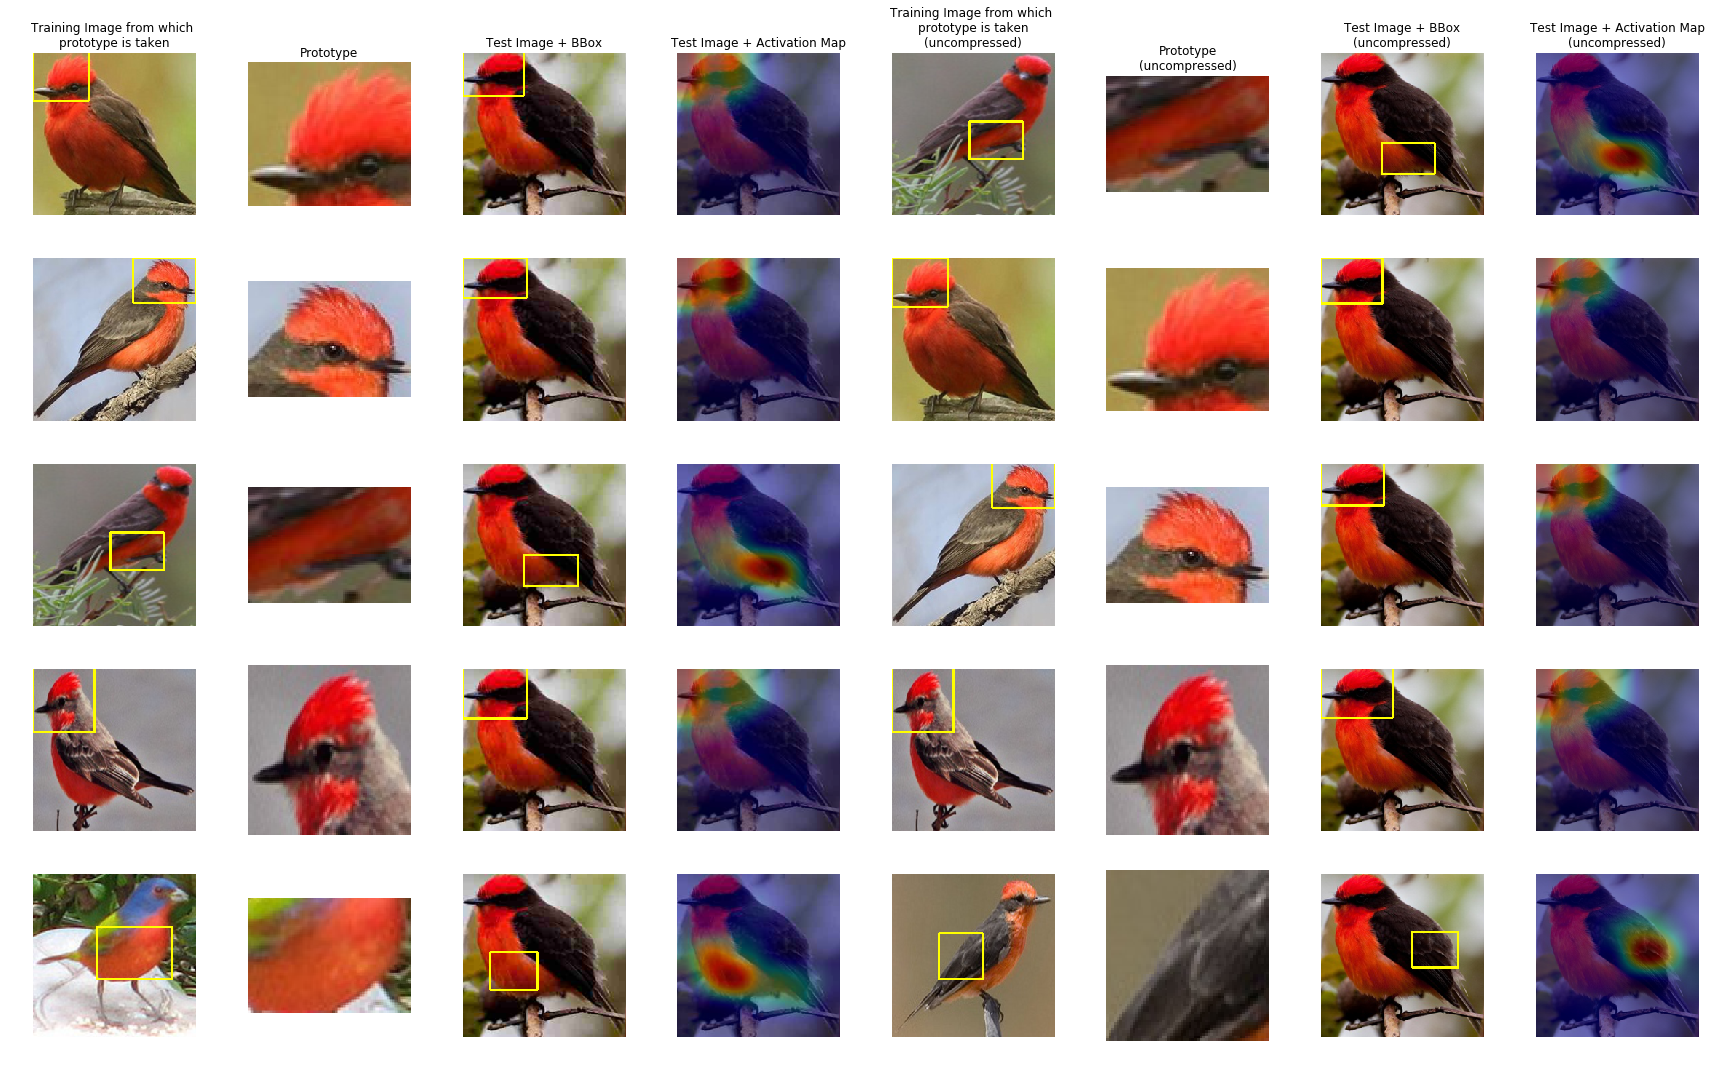

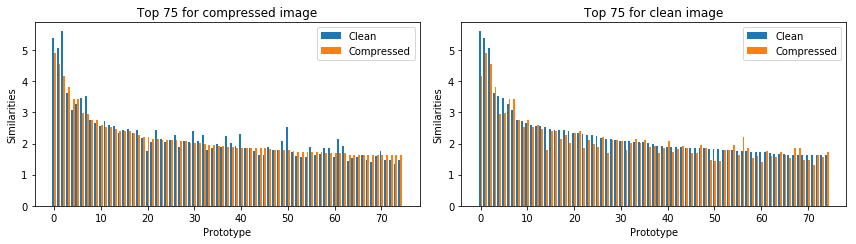

In [39]:
JPEG_QUALITY = 20

# Retrieve test data classes
classes = sorted(os.listdir(directory_test))

sample_images = 10
"""
# Loop over every fourth class, which has also been compressed during training
for i in range(sample_images):
    # Calculate the test image label
    test_image_label = (len(classes)//sample_images)*i+1
"""

for x,y,test_dr, model_name in zip(test_images, test_labels, test_dirs, model_names):
    # Choose an odd class: that's why we add +1 in the index
    # If we don't add 1, then we only inspect even classes, and we can see the inverse effect
    test_image_dir = directory_test+test_dr
    image_list = os.listdir(test_image_dir)
    test_image_label = y
    # Index for test images
    j = 1
    test_image_path = os.path.join(directory_test, x)

    # Compression Processing Pipeline
    preprocess_corrupted = transforms.Compose([
                transforms.Lambda(JPEGcompression),
                transforms.Resize(size=(img_size, img_size)),
                transforms.ToTensor(),
                normalize,
            ])
    
    # Normal Processing Pipeline
    preprocess_clean = transforms.Compose([
                transforms.Resize(size=(img_size, img_size)),
                transforms.ToTensor(),
                normalize,
            ])

    img_pil = Image.open(test_image_path)

    # Show the results
    loc_analysis.jpeg_visualization2(img_pil, x, 
                                     test_image_label,
                                     preprocess_clean, preprocess_corrupted, 
                                     show_images=True, max_prototypes=5, 
                                     save_histogram=True, 
                                     save_name = "histogram_{}_robust".format(model_name))
    print("============================================================================================")
    print("")

In [ ]:
!rm -rf /scratch/PPNet